## Import

In [1]:
import pandas as pd
import numpy as np
import os
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, log_loss
from tqdm import tqdm
import polars as pl

import lightgbm as lgb
import pickle
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/cupy/_environment.py:596: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda11x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


## Setting

In [2]:
CFG = {
    'BATCH_SIZE': 3072,
    'EPOCHS': 10,
    'LEARNING_RATE': 2e-3,
    'SEED' : 42
}
# device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

seed_everything(CFG['SEED']) # Seed 고정

## Data Load

In [4]:
# 데이터 로드
all_train = pl.read_parquet("../data/train.parquet")
test = pl.read_parquet("../data/test.parquet").drop(["ID"])

print("Train shape:", all_train.shape)
print("Test shape:", test.shape)

Train shape: (10704179, 119)
Test shape: (1527298, 118)


## Data Down-Sampling

In [5]:
# clicked == 1 데이터
clicked_1 = all_train.filter(pl.col("clicked") == 1)

# clicked == 0 데이터에서 동일 개수x2 만큼 무작위 추출 (다운 샘플링)
clicked_0 = all_train.filter(pl.col("clicked") == 0).sample(
    n=clicked_1.height * 2, 
    seed=42
)

# 두 데이터프레임 합치기
train = (
    pl.concat([clicked_1, clicked_0], how="vertical")  # axis=0과 동일
      .sample(fraction=1.0, shuffle=True, seed=42)     # frac=1과 동일
      # Polars에는 index가 없으므로 reset_index(drop=True)는 불필요
)

In [6]:
print("Train shape:", train.shape)
print("Train clicked:0:", train.filter(pl.col("clicked") == 0).shape)
print("Train clicked:1:", train.filter(pl.col("clicked") == 1).shape)

Train shape: (612537, 119)
Train clicked:0: (408358, 119)
Train clicked:1: (204179, 119)


## Data Column Setting

In [7]:
# Target / Sequence
target_col = "clicked"
seq_col = "seq"

# 학습에 사용할 피처: ID/seq/target 제외, 나머지 전부
FEATURE_EXCLUDE = {target_col, seq_col, "ID"}
feature_cols = [c for c in train.columns if c not in FEATURE_EXCLUDE]

print("Num features:", len(feature_cols))
print("Sequence:", seq_col)
print("Target:", target_col)

Num features: 117
Sequence: seq
Target: clicked


In [8]:
def extract_sequence_features(df, seq_col):
    """시퀀스 데이터를 통계 특성으로 변환"""
    seq_features = []
    
    # polars DataFrame을 pandas로 변환
    seq_series = df[seq_col].to_pandas()
    
    for seq_str in seq_series:
        if seq_str and str(seq_str) != 'null':
            try:
                arr = np.fromstring(str(seq_str), sep=",", dtype=np.float32)
                if arr.size > 0:
                    features = {
                        'seq_mean': arr.mean(),
                        'seq_std': arr.std() if arr.size > 1 else 0.0,
                        'seq_min': arr.min(),
                        'seq_max': arr.max(),
                        'seq_len': len(arr),
                        'seq_sum': arr.sum(),
                        'seq_median': np.median(arr),
                    }
                else:
                    features = {k: 0.0 for k in ['seq_mean', 'seq_std', 'seq_min', 'seq_max', 'seq_len', 'seq_sum', 'seq_median']}
            except:
                features = {k: 0.0 for k in ['seq_mean', 'seq_std', 'seq_min', 'seq_max', 'seq_len', 'seq_sum', 'seq_median']}
        else:
            features = {k: 0.0 for k in ['seq_mean', 'seq_std', 'seq_min', 'seq_max', 'seq_len', 'seq_sum', 'seq_median']}
            
        seq_features.append(features)
    
    seq_df = pd.DataFrame(seq_features)
    seq_df = seq_df.fillna(0.0)
    return seq_df

## Define Custom Dataset

In [9]:
def prepare_data(df, feature_cols, seq_col, target_col=None, has_target=True):
    """LightGBM용 데이터 준비"""
    # 기존 tabular 특성
    X_tabular = df.select(feature_cols).cast(pl.Float64).fill_null(0).to_pandas()
    
    # 시퀀스 특성 추출
    seq_df = extract_sequence_features(df, seq_col)
    
    # 특성 결합
    X_combined = pd.concat([X_tabular, seq_df], axis=1)
    
    if has_target:
        y = df[target_col].cast(pl.Float32).to_pandas().values
        return X_combined, y
    else:
        return X_combined

In [10]:
def collate_fn_train(batch):
    xs, seqs, ys = zip(*batch)
    xs = torch.stack(xs)
    ys = torch.stack(ys)
    seqs_padded = nn.utils.rnn.pad_sequence(seqs, batch_first=True, padding_value=0.0)
    seq_lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)
    seq_lengths = torch.clamp(seq_lengths, min=1)  # 빈 시퀀스 방지
    return xs, seqs_padded, seq_lengths, ys

def collate_fn_infer(batch):
    xs, seqs = zip(*batch)
    xs = torch.stack(xs)
    seqs_padded = nn.utils.rnn.pad_sequence(seqs, batch_first=True, padding_value=0.0)
    seq_lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)
    seq_lengths = torch.clamp(seq_lengths, min=1)
    return xs, seqs_padded, seq_lengths

## Define Model Architecture

In [11]:
# class TabularSeqModel(nn.Module):
#     def __init__(self, d_features, lstm_hidden=32, hidden_units=[1024, 512, 256, 128], dropout=0.2):
#         super().__init__()
#         # 모든 비-시퀀스 피처에 BN
#         self.bn_x = nn.BatchNorm1d(d_features)
#         # seq: 숫자 시퀀스 → LSTM
#         self.lstm = nn.LSTM(input_size=1, hidden_size=lstm_hidden, batch_first=True)

#         # 최종 MLP
#         input_dim = d_features + lstm_hidden
#         layers = []
#         for h in hidden_units:
#             layers += [nn.Linear(input_dim, h), nn.ReLU(), nn.Dropout(dropout)]
#             input_dim = h
#         layers += [nn.Linear(input_dim, 1)]
#         self.mlp = nn.Sequential(*layers)

#     def forward(self, x_feats, x_seq, seq_lengths):
#         # 비-시퀀스 피처
#         x = self.bn_x(x_feats)

#         # 시퀀스 → LSTM (pack)
#         x_seq = x_seq.unsqueeze(-1)  # (B, L, 1)
#         packed = nn.utils.rnn.pack_padded_sequence(
#             x_seq, seq_lengths.cpu(), batch_first=True, enforce_sorted=False
#         )
#         _, (h_n, _) = self.lstm(packed)
#         h = h_n[-1]                  # (B, lstm_hidden)

#         z = torch.cat([x, h], dim=1)
#         return self.mlp(z).squeeze(1)  # logits

## Train / Validation

In [12]:
def train_model(train_df, feature_cols, seq_col, target_col,
                batch_size=CFG['BATCH_SIZE'], epochs=CFG['EPOCHS'], lr=CFG['LEARNING_RATE'], device="cuda"):
    """
    원본 함수명 유지하면서 LightGBM으로 교체
    기존 파라미터도 유지 (사용하지 않지만 호환성 위해)
    """
    
    print("🔄 데이터 전처리 중...")
    
    # 1. 데이터 준비
    X, y = prepare_data(train_df, feature_cols, seq_col, target_col, has_target=True)
    
    # 2. Train/Validation 분할
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )
    
    print(f"📊 학습 데이터: {X_train.shape}, 검증 데이터: {X_val.shape}")
    
    # 3. LightGBM 데이터셋 생성
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    # 4. LightGBM 파라미터
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.1,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': 42,
    }
    
    # 5. 모델 학습 (epochs 파라미터 활용)
    print(f"🚀 LightGBM 학습 시작... (epochs={epochs} → {epochs*100} rounds)")
    model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=epochs * 100,  # epochs를 rounds로 변환
        callbacks=[
            lgb.log_evaluation(period=50),
            lgb.early_stopping(stopping_rounds=50)
        ]
    )
    
    # 6. 검증 성능
    val_preds = model.predict(X_val)
    val_loss = log_loss(y_val, val_preds)
    
    print(f"✅ 학습 완료! Validation LogLoss: {val_loss:.4f}")
    
    return model


## Run!!

In [13]:
model = train_model(
    train_df=train,
    feature_cols=feature_cols,
    seq_col=seq_col,
    target_col=target_col,
    batch_size=CFG['BATCH_SIZE'],
    epochs=CFG['EPOCHS'],
    lr=CFG['LEARNING_RATE'],
    # device=device
)

🔄 데이터 전처리 중...
📊 학습 데이터: (490029, 124), 검증 데이터: (122508, 124)
🚀 LightGBM 학습 시작... (epochs=10 → 1000 rounds)
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.555492
[100]	valid_0's binary_logloss: 0.551241
[150]	valid_0's binary_logloss: 0.550189
[200]	valid_0's binary_logloss: 0.549651
[250]	valid_0's binary_logloss: 0.549406
[300]	valid_0's binary_logloss: 0.549206
[350]	valid_0's binary_logloss: 0.54917
[400]	valid_0's binary_logloss: 0.548956
[450]	valid_0's binary_logloss: 0.54896
Early stopping, best iteration is:
[442]	valid_0's binary_logloss: 0.548913
✅ 학습 완료! Validation LogLoss: 0.5489


In [ ]:
def calculate_competition_score(y_true, y_pred):
    """대회 평가지표 계산: AP 50% + WLL 50%"""
    
    # Average Precision (50%)
    ap_score = average_precision_score(y_true, y_pred)
    
    # Weighted LogLoss (50%) - 클래스별 50:50 가중치
    n_pos = np.sum(y_true)
    n_neg = len(y_true) - n_pos
    
    # 50:50 비율로 가중치 조정
    pos_weight = 0.5 / (n_pos / len(y_true)) if n_pos > 0 else 1.0
    neg_weight = 0.5 / (n_neg / len(y_true)) if n_neg > 0 else 1.0
    
    # 가중 로그손실 계산
    sample_weights = np.where(y_true == 1, pos_weight, neg_weight)
    wll_score = log_loss(y_true, y_pred, sample_weight=sample_weights)
    
    # 최종 점수 계산 (정규화 방식 수정)
    final_score = 0.5 * ap_score + 0.5 * (1 / ( 1 + wll_score))
    
    return {
        'AP': ap_score,
        'WLL': wll_score, 
        'Competition_Score': final_score
    }

# train_model 함수에서 반환된 데이터로 평가
# 기존 함수가 model만 반환하므로 데이터를 다시 준비해야 함
print("📊 대회 평가지표 계산 중...")
X, y = prepare_data(train, feature_cols, seq_col, target_col, has_target=True)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

val_preds = model.predict(X_val)
scores = calculate_competition_score(y_val, val_preds)

print(f"🎯 대회 평가 결과:")
print(f"   AP (Average Precision): {scores['AP']:.4f}")
print(f"   WLL (Weighted LogLoss): {scores['WLL']:.4f}") 
print(f"   Competition Score: {scores['Competition_Score']:.4f}")

📊 대회 평가지표 계산 중...
🎯 대회 평가 결과:
   AP (Average Precision): 0.6069
   WLL (Weighted LogLoss): 0.6462
   Competition Score: 0.4804


In [15]:
# ====================
#  Model Save
# ====================

# 타임스탬프 포함 파일명 생성
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"lgb_model_{timestamp}.pkl"

# 모델 저장
with open(model_filename, 'wb') as f:
    pickle.dump(model, f)

print(f"💾 모델 저장 완료: {model_filename}")
print(f"📁 저장 경로: {os.path.abspath(model_filename)}")

# 모델 정보 출력
print(f"🤖 모델 정보:")
print(f"   - 특성 수: {model.num_feature()}")
print(f"   - 트리 수: {model.num_trees()}")
print(f"   - 최적 반복: {model.best_iteration}")

# 설정 정보도 함께 저장
config_data = {
    'feature_cols': feature_cols,
    'seq_col': seq_col,
    'target_col': target_col,
    'CFG': CFG,
    'train_shape': train.shape,
    'model_type': 'LightGBM'
}

config_filename = f"config_{timestamp}.pkl"
with open(config_filename, 'wb') as f:
    pickle.dump(config_data, f)

print(f"⚙️  설정 저장 완료: {config_filename}")

💾 모델 저장 완료: lgb_model_20250917_144747.pkl
📁 저장 경로: /toss-ad-click-prediction/notebooks/lgb_model_20250917_144747.pkl
🤖 모델 정보:
   - 특성 수: 124
   - 트리 수: 442
   - 최적 반복: 442
⚙️  설정 저장 완료: config_20250917_144747.pkl


In [16]:
# # ====================
# # 📂 Model Load (필요시 사용)
# # ====================
# # 저장된 모델 로드하는 경우
# model_filename = "lgb_model_20240917_143022.pkl"  # 실제 파일명으로 변경

# with open(model_filename, 'rb') as f:
#     model = pickle.load(f)

# print(f"✅ 모델 로드 완료: {model_filename}")

## Inference

In [17]:
print("🔮 추론 시작...")

# 1. 테스트 데이터 준비
X_test = prepare_data(test, feature_cols, seq_col, has_target=False)

# 2. 예측
test_preds = model.predict(X_test)

print(f"✅ 추론 완료! 예측값 범위: {test_preds.min():.4f} ~ {test_preds.max():.4f}")

🔮 추론 시작...


✅ 추론 완료! 예측값 범위: 0.0283 ~ 0.9965


/tmp/ipykernel_172246/2956658547.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df, x="importance", y="feature", palette="viridis")


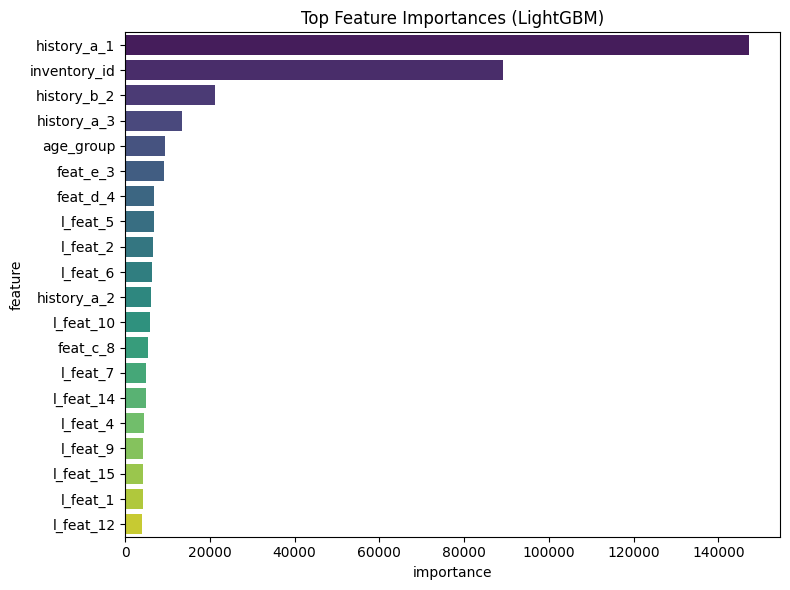

In [18]:
def plot_feature_importance(model, feature_cols, top_n=20):
    """LightGBM feature importance 시각화"""
    # feature_cols와 시퀀스 특성을 결합한 전체 특성명
    seq_features = ['seq_mean', 'seq_std', 'seq_min', 'seq_max', 'seq_len', 'seq_sum', 'seq_median']
    all_features = feature_cols + seq_features
    
    fi_df = pd.DataFrame({
        "feature": all_features,
        "importance": model.feature_importance(importance_type='gain')  # LightGBM의 feature_importance 사용
    }).sort_values("importance", ascending=False).head(top_n)

    plt.figure(figsize=(8, 6))
    sns.barplot(data=fi_df, x="importance", y="feature", palette="viridis")
    plt.title("Top Feature Importances (LightGBM)")
    plt.tight_layout()
    plt.show()

# 실행
plot_feature_importance(model, feature_cols)

## Submission

In [20]:
submit = pl.read_csv("../data/sample_submission.csv")
submit = submit.with_columns(pl.Series("clicked", test_preds))

In [ ]:
submit.write_csv("./baseline_submit.csv")

: 